# Fine-tuning BERT for intention classification

## 환경 설정

HuggingFace Transformers, Datasets 라이브러리를 설치합니다.

참고 : [HuggingFace Transformers](https://huggingface.co/docs)

In [ ]:
!pip install -q transformers datasets

     |████████████████████████████████| 4.9 MB 30.1 MB/s 
     |████████████████████████████████| 365 kB 60.7 MB/s 
     |████████████████████████████████| 120 kB 69.2 MB/s 
     |████████████████████████████████| 6.6 MB 52.8 MB/s 
     |████████████████████████████████| 212 kB 67.3 MB/s 
     |████████████████████████████████| 115 kB 70.6 MB/s 
     |████████████████████████████████| 127 kB 71.5 MB/s 


## 복습

## Load dataset

업로드한 데이터를 로드하기 위해 드라이브에 마운트합니다.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/중정처1주차/"

 7_Fine_tuning_BERT_for_text_classification.ipynb
'중정처_BERT_데이터구축.ipynb의 사본'
 df_text.csv
 df_text.csv.gsheet
 exfile.ipynb
 extext2.txt
 extext.csv
 extext.txt
 HW_question.ipynb
 original.csv
 preprocess_data_실습.ipynb
'preprocess_data.ipynb의 사본'
 processed.csv
 processed_eval.csv
 processed_test.csv
 processed_train.csv
 Q1.txt
 Q2.txt
'regex (1).ipynb'
 regex.ipynb
 regex_Wanswer멘토용.ipynb
'split_data.ipynb의 사본'


## 미리 나눠놓은 train.csv, test.csv 파일을 불러옵니다.

In [ ]:
train_data = "/content/drive/MyDrive/중정처1주차/processed_train.csv"
eval_data = "/content/drive/MyDrive/중정처1주차/processed_eval.csv"
test_data = "/content/drive/MyDrive/중정처1주차/processed_test.csv"

### datasets 를 이용해 train, test 파일을 로드합니다.

In [ ]:
from datasets import load_dataset, ReadInstruction

dataset = load_dataset('csv', data_files={'train': train_data, 'eval': eval_data, 'test': test_data})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-853ab72b57001897/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### train과 test가 로드 된것을 확인합니다.
과제를 수행할 때에는 train / validataion / test 데이터로 분리해서 사용합니다.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'utt', '관광지 추천', '날씨 묻기', '맛집 추천', '숙소 추천', '인사', '카페 추천', '활동 추천'],
        num_rows: 3021
    })
    eval: Dataset({
        features: ['Unnamed: 0', 'utt', '관광지 추천', '날씨 묻기', '맛집 추천', '숙소 추천', '인사', '카페 추천', '활동 추천'],
        num_rows: 378
    })
    test: Dataset({
        features: ['Unnamed: 0', 'utt', '관광지 추천', '날씨 묻기', '맛집 추천', '숙소 추천', '인사', '카페 추천', '활동 추천'],
        num_rows: 377
    })
})

train 데이터의 첫 번째 데이터를 확인해봅니다.

In [ ]:
example = dataset['train'][0]
example

{'Unnamed: 0': 779,
 'utt': '부산 디저트 많은 곳 알려주세요',
 '관광지 추천': 0,
 '날씨 묻기': 0,
 '맛집 추천': 0,
 '숙소 추천': 0,
 '인사': 0,
 '카페 추천': 1,
 '활동 추천': 0}

데이터를 살펴보면 인덱스, 발화, 라벨로 이뤄져있습니다.

라벨만 따로 리스트에 저장하고 각각의 라벨을 정수에 매핑합니다. 

매핑된 것은 dictionary로 만들어줍니다.

In [ ]:
labels = [label for label in dataset['train'].features.keys() if label not in ['Unnamed: 0', 'utt']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
print(labels)
print(id2label)
print(label2id)

['관광지 추천', '날씨 묻기', '맛집 추천', '숙소 추천', '인사', '카페 추천', '활동 추천']
{0: '관광지 추천', 1: '날씨 묻기', 2: '맛집 추천', 3: '숙소 추천', 4: '인사', 5: '카페 추천', 6: '활동 추천'}
{'관광지 추천': 0, '날씨 묻기': 1, '맛집 추천': 2, '숙소 추천': 3, '인사': 4, '카페 추천': 5, '활동 추천': 6}


## Preprocess data

BERT는 텍스트가 아닌 `input_ids`를 입력으로 받습니다. 이를 위해 우선 훈련된 토크나이저를 활용해 텍스트를 토큰화합니다. 

이번 예시에서는 `AutoTokenizer`를 활용해 토큰화를 진행합니다.

In [ ]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base") ## 우리가 사용할 버트 모델이 학습되었을 당시에 사용되었던 토크나이저를 로드 (버전별 사전 상이하기 때문)

def preprocess_data(examples):
  # 배치화된 텍스트를 받습니다.
  text = examples["utt"]
  # 인코딩 합니다.
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # 라벨을 배치로 만들어줍니다. (인덱스, 발화 제외하기 위해 if문 활용)
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # numpy array로 만들기 위해 0 매트릭스를 만들어줍니다.
  labels_matrix = np.zeros((len(text), len(labels))) # 텍스트 개수(2) x 레이블 개수(7)
  # 채웁니다.
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

인코딩!

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)
# labels_batch 이용
# column_names 새롭게 지정

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3021
    })
    eval: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 378
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 377
    })
})

결과 확인

In [ ]:
example = encoded_dataset['train'][0]
print(example.keys())
print(example)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
{'input_ids': [2, 3902, 10058, 1039, 2073, 601, 3922, 2223, 5971, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
tokenizer.decode(example['input_ids'])

'[CLS] 부산 디저트 많은 곳 알려주세요 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
example['labels']

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

인코딩된 데이터를 파이토치의 포맷에 맞게 변경합니다.
[참조](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Dataset.set_format)

In [ ]:
encoded_dataset.set_format("torch")

복습 끝

## 모델 정의

모델을 정의하기 위해 `transformers`에서 제공하는 `AutoModelForSequenceClassification` 모듈을 import합니다. 

pretrained된 모델의 weight를 로드하면 text classification을 위한 layer가 random한 weight로 생성됩니다.

  - 즉 의도 분류를 위한 훈련 시, layer별 가중치를 알아서 설정해준다.
  - 의도 분류(sequence classification) 이외에도 여러 도메인에 대한 AutoModel들이 있음

가중치? (weight, w)

ex. 월별 모의고사 점수 => 수능 성적 예측

  - 월별 점수를 모두 같은 가중치로 산정해야 할까?

입력층에서 다음 '노드'로 넘어갈때, 모두 같은값이면 계속 같은 값이 나오게 된다.

즉 데이터마다 ***각각 다른 비중으로*** 학습시키기 위해 곱해주는 값이 바로 가중치(weight)이다.

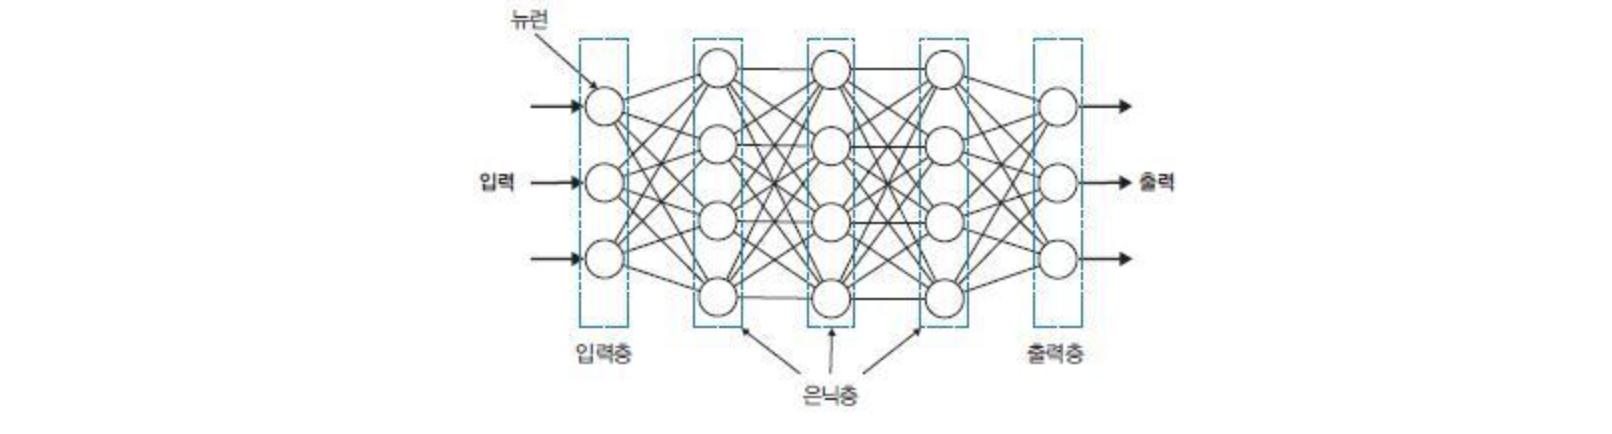

In [ ]:
from transformers import AutoModelForSequenceClassification

# 우리가 사용할 버트 모델이 학습되었을 당시에 사용되었던 버젼을 로드
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

## 모델 훈련

허깅페이스에서 제공하는 Trainer API를 사용해 훈련을 시킵니다. 이를 위해 `TrainingArguments`와 `Trainer`를 정의해줘야 합니다.

* `TrainingArguments` : [문서](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments)
* `Trainer` : [참조](https://huggingface.co/transformers/main_classes/trainer.html#id1)

- trainer : 모델 훈련을 위한 모듈
- trainingarguments : 훈련 시 사용자 커스터마이징을 위한 모듈

In [ ]:
batch_size = 8
metric_name = "acc"

# metric = 측정 기준
# Accuracy : 정답인 경우의 수 / 추측한 모든 경우의 수

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned",
    evaluation_strategy = "epoch", # 각 훈련횟수 마지막에 평가 (한 epoch이 끝나면 evaluation이 평가됨)
    save_strategy = "epoch",
    learning_rate=2e-5, # 학습 속도
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3, #한번에 학습시킬 수 있는 데이터의 수
    weight_decay=0.01, # 과적합 방지
    load_best_model_at_end=True,
    metric_for_best_model=metric_name, # acc
    #push_to_hub=True,
)

학습 속도? (theta = w)

우리는 정답 숫자와 가까워지도록 (ex. "가수이름으로 노래 / 노래제목으로 노래 / 노래중지" 각각의 점수) weight값을 조정한다고 했다.

  - 가로축 : w
  - 세로축 : cost (손실)

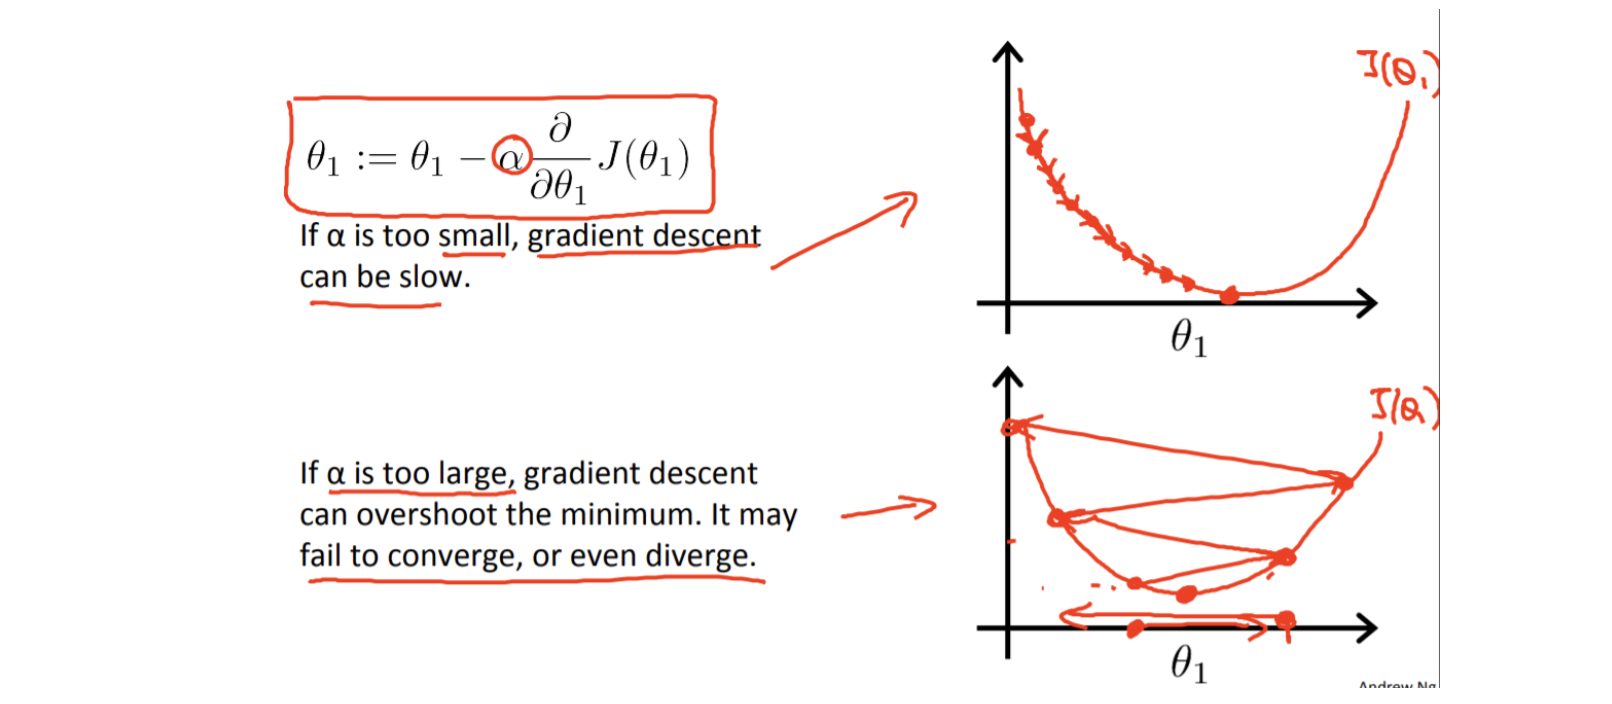

훈련을 위해서는 `compute_metrics` 함수를 정의해야합니다.

In [ ]:
from sklearn.metrics import accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
# 쉽게 말해 "모델의 성능을 평가하기 위한 측정기준"을 세우는 것

def acc_metrics(predictions, labels):
    probs = torch.Tensor(predictions)
    # 최대값을 1로 변경합니다.
    y_pred = np.zeros(probs.shape)
    y_pred[np.arange(len(probs)), probs.argmax(1)] = 1
    # metric을 계산합니다.
    y_true = labels
    accuracy = accuracy_score(y_true, y_pred)
    # dictionary를 리턴합니다.
    metrics = {'acc': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = acc_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

훈련 시작!

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

#데이터가 적으면 조금만 epoch돌려도 과적합 나타남

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3021
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1134
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Acc
1,No log,0.021752,1.000000
2,0.083900,0.012496,1.000000
3,0.014900,0.010656,1.000000


***** Running Evaluation *****
  Num examples = 377
  Batch size = 8
Saving model checkpoint to bert-finetuned/checkpoint-378
Configuration saved in bert-finetuned/checkpoint-378/config.json
Model weights saved in bert-finetuned/checkpoint-378/pytorch_model.bin
tokenizer config file saved in bert-finetuned/checkpoint-378/tokenizer_config.json
Special tokens file saved in bert-finetuned/checkpoint-378/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 377
  Batch size = 8
Saving model checkpoint to bert-finetuned/checkpoint-756
Configuration saved in bert-finetuned/checkpoint-756/config.json
Model weights saved in bert-finetuned/checkpoint-756/pytorch_model.bin
tokenizer config file saved in bert-finetuned/checkpoint-756/tokenizer_config.json
Special tokens file saved in bert-finetuned/checkpoint-756/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 377
  Batch size = 8
Saving model checkpoint to bert-finetuned/checkpoint-1134
Configuration sav

TrainOutput(global_step=1134, training_loss=0.044996034951857576, metrics={'train_runtime': 267.0437, 'train_samples_per_second': 33.938, 'train_steps_per_second': 4.246, 'total_flos': 596170636358400.0, 'train_loss': 0.044996034951857576, 'epoch': 3.0})

## Evaluate

훈련 후에는 validation data를 이용해 모델을 평가합니다.

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 377
  Batch size = 8


{'eval_loss': 0.02175208181142807,
 'eval_acc': 1.0,
 'eval_runtime': 2.9809,
 'eval_samples_per_second': 126.471,
 'eval_steps_per_second': 16.102,
 'epoch': 3.0}

## 훈련이 완료된 모델을 드라이브에 저장합니다.

In [ ]:
# 모델을 저장하고 싶은 경로를 설정해주세요.
trainer.save_model('/content/drive/MyDrive/중정처1주차/my_model')

#pytorch_model.bin 파일이 핵심 (벡터로 변환된 것들이 저장되어 있는 binary파일)

Saving model checkpoint to /content/drive/MyDrive/중정처1주차/my_model
Configuration saved in /content/drive/MyDrive/중정처1주차/my_model/config.json
Model weights saved in /content/drive/MyDrive/중정처1주차/my_model/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/중정처1주차/my_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/중정처1주차/my_model/special_tokens_map.json
